# Data Preperation

- Removed eICU rows...
- Combined ID and Maßnahme and drop ID...
- Dropped Maßnahme_norm...
- Pivoted Table...
- Cleaned column names
- shifted relative time to start at 0...
- merge personal data with main data

from preprocessor.preprocessor import PreprocessingPipeline## Imports

In [26]:
# data processing
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

## Preperation & Cleaning

In [3]:
def change_rel_time(group):
    group["rel_time"] -= min(group["rel_time"])
    
    group["rel_time_hour"] =  group["rel_time"] / 60
    group["rel_time_hour"] = group["rel_time_hour"].apply(np.floor)
    group["rel_time_hour"] = group["rel_time_hour"].astype(int).round(0)
    return group

In [4]:
path = "../master-thesis/data/datenbank_werte_df.parquet"

# Load the dataset
datenbank_werte_df = pd.read_parquet(path)
print("Dataset loaded...")

# Only select rows that are from the UKE Database
datenbank_werte_df = datenbank_werte_df[datenbank_werte_df["DB"] == "UKE"]
print("Removed eICU rows...")

# We can combine the Maßnahme with the ID column, becasue there is no extra information
datenbank_werte_df["Maßnahme"] += "_" + datenbank_werte_df["ID"]
datenbank_werte_df = datenbank_werte_df.drop(columns="ID")
print("Combined ID and Maßnahme and drop ID...")

# Droppinbg Maßname_norm since it's irrelevant when working only with UKE data
datenbank_werte_df = datenbank_werte_df.drop(columns="Maßnahme_norm")
print("Dropped Maßnahme_norm...")

# Change the dataframe from a long format to a wide format
datenbank_werte_df = datenbank_werte_df.pivot_table(index=["rel_time", "Pat_ID", "DB"], columns="Maßnahme", values="Wert").reset_index()
print("Pivoted Table...")

# change the column names to better more uniform column names
datenbank_werte_df.columns = [x.lower().replace(" ", "_").replace("-", "_") for x in datenbank_werte_df.columns]
print("Cleaned column names")

# Shift the rel_time so that it begins at 0
datenbank_werte_df = datenbank_werte_df.groupby("pat_id").apply(lambda group: change_rel_time(group))
print("shifted relative time to start at 0...")

# Merge down columns to a 60 minute format
datenbank_werte_df.set_index(['pat_id', 'rel_time'])    
datenbank_werte_df = datenbank_werte_df.groupby(["pat_id","rel_time_hour"]).mean().reset_index()
datenbank_werte_df["rel_time"] = datenbank_werte_df["rel_time_hour"] * 60
datenbank_werte_df = datenbank_werte_df.drop(columns="rel_time_hour")

# remove patient with pat_id '123456798'
datenbank_werte_df = datenbank_werte_df[datenbank_werte_df['pat_id'] != '123456798']

# Add patients data to the timeseries data.

datenbank_werte_df.head()

Dataset loaded...
Removed eICU rows...
Combined ID and Maßnahme and drop ID...
Dropped Maßnahme_norm...
Pivoted Table...
Cleaned column names
shifted relative time to start at 0...


,pat_id,rel_time,af_vital,alt_labor,ast_labor,albumin_labor,alk_labor,alpha_blocker_med,barbiturat_med,basophile_labor,...,diast_vital,ft3_labor,ft4_labor,mittl_nbd_vital,mittl_vital,ph_bga,pankreasspez_labor,so2_bga,syst_nbd_vital,syst_vital
30,474096103,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81.0,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,130.0
31,474096103,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67.5,NaN,NaN,NaN,93.0,NaN,NaN,NaN,NaN,134.0
32,474096103,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,70.0,NaN,NaN,NaN,94.0,NaN,NaN,NaN,NaN,133.0
33,474096103,180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,67.0,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN,128.0
34,474096103,240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,62.0,NaN,NaN,NaN,86.0,NaN,NaN,NaN,NaN,125.0


In [5]:
datenbank_werte_df.to_parquet("../master-thesis/data/uke_data_wide.parquet")

## Merge UKE data with personal information

In [21]:
# Load the datasets
path = "../master-thesis/data/uke_data_wide.parquet"
uke_df = pd.read_parquet(path)

path = "../master-thesis/data/pat_id_data.csv"
uke_personal_data_df = pd.read_csv(path)

# left-join the datasets
uke_raw = pd.merge(uke_df,uke_personal_data_df,on='pat_id',how='left')

drop = ['database', 'diagnose', 'outcome', 'outcome_house']
uke_raw = uke_raw.drop([x for x in drop if x in uke_raw.columns], axis=1)

# Label encode the sex
le = LabelEncoder()
uke_raw['sex'] = le.fit_transform(uke_raw['sex'])

In [22]:
uke_raw.to_parquet("../master-thesis/data/uke_clean.parquet")

## Power transform (Box cox and yoe johnson)

In [78]:
# Check skewness for each value

skewness_values = {}
for column_name in uke_raw.columns:
    skew = uke_raw[column_name].skew()
    skewness_values[column_name] = np.round(skew,4)
    
    
for column_name,skew in {k: v for k, v in sorted(skewness_values.items(), key=lambda item: item[1])}.items():
    print("{:<26}: {}".format(column_name,skew))


spo2_vital                : -6.949
so2_bga                   : -2.3709
mcv_labor                 : -1.427
height                    : -1.1997
cpp_vital                 : -0.7504
age                       : -0.3344
sbe_bga                   : -0.2368
syst_vital                : -0.1325
hco3_bga                  : -0.0101
neutrophile_labor         : 0.0769
rass_vital                : 0.1858
pat_id                    : 0.2071
syst_nbd_vital            : 0.2531
mittl_nbd_vital           : 0.3037
diast_nbd_vital           : 0.306
hf_vital                  : 0.3678
ppeak_vital               : 0.3863
sex                       : 0.431
cl_bga                    : 0.5993
gcs_auge_vital            : 0.6764
hk_labor                  : 0.7727
hb_bga_bga                : 0.8473
pmean_vital               : 0.8563
length_of_stay            : 0.9121
fcohb_bga                 : 0.9233
peep_vital                : 0.9582
weight                    : 0.9839
gcs_motor_vital           : 1.0353
cholesterin_lab

In [85]:
pt = PowerTransformer()
uke_raw = pt.fit_transform(uke_raw)

/home/yannic/anaconda3/envs/jupyter-lab/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [93]:
print(pt.fit_transform.__doc__)

Fit `PowerTransformer` to `X`, then transform `X`.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data used to estimate the optimal transformation parameters
            and to be transformed using a power transformation.

        y : Ignored
            Not used, present for API consistency by convention.

        Returns
        -------
        X_new : ndarray of shape (n_samples, n_features)
            Transformed data.
        


In [90]:
uke_df = pd.DataFrame(uke_raw)

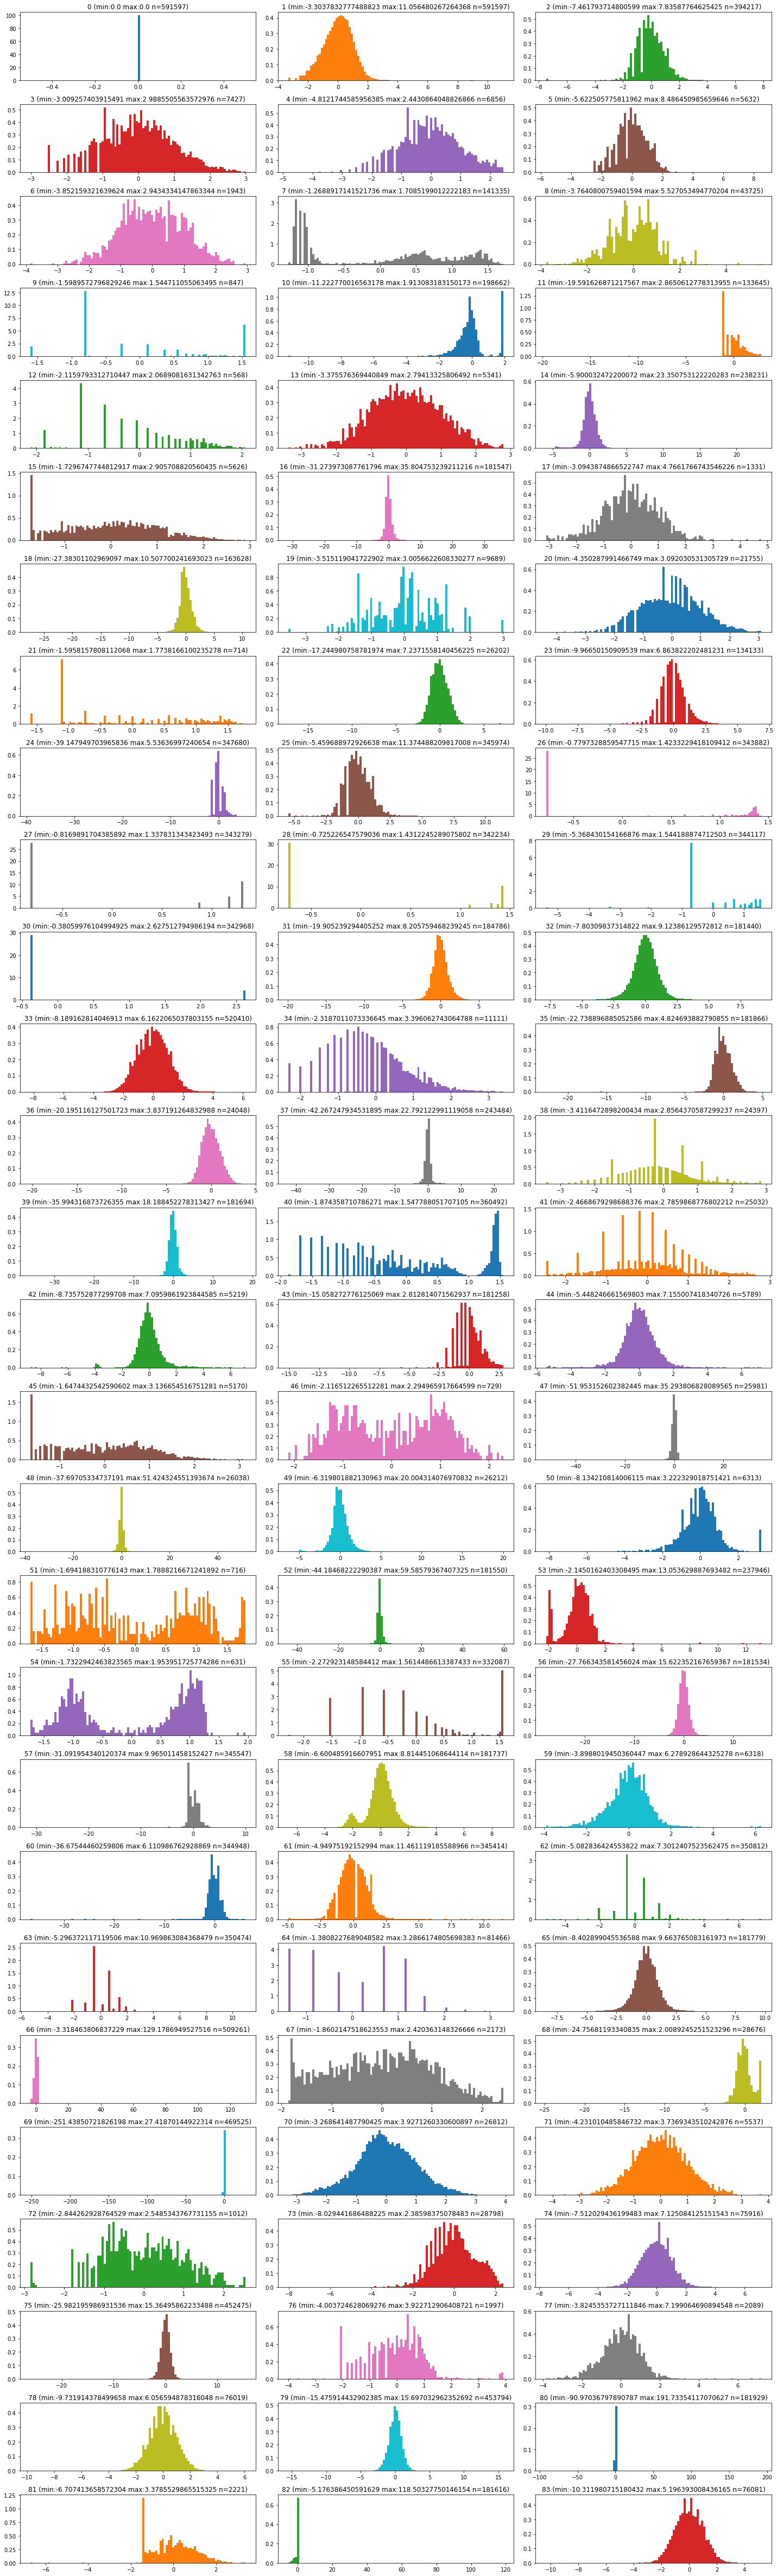

In [92]:
fig, axs = plt.subplots(28, 3)
fig.set_figheight(66)
fig.set_figwidth(20)

colors = plt.rcParams["axes.prop_cycle"]()

for i, ax in enumerate(fig.axes):
        
        if i < len(uke_df.columns) and uke_df.columns[i] != "pat_id":
            
            # get column name
            column_name = uke_df.columns[i]
            print("Creating column {}/{} - {}".format(i, len(uke_df.columns), column_name), end="\r")
            
            # Extract data
            series = uke_df[column_name].dropna()
            
            # Create subplot
            color = next(colors)["color"]
            
            ax.hist(series, density=True, bins=100, color= color, range=(series.min(), series.max()))
            ax.set_title(str(column_name) +" (min:{} max:{} n={})".format(series.min(),series.max(), series.count()))

            
fig.tight_layout()        
fig.savefig("../master-thesis/figures/column_distribution.png")